# Multi-Model Market Forecasting & Risk Engine

**Industrial-Grade Two-Step ARIMA-GARCH Implementation**

| Model | Type | Approach |
|-------|------|----------|
| **ARIMA-GARCH** | Econometric | Two-step: ARIMA (statsmodels) → GARCH on residuals |
| **XGBoost** | ML | Lagged features + walk-forward validation |
| **LSTM** | Deep Learning | Sequence-based RNN |

---

## Table of Contents

1. [Setup & Configuration](#setup)
2. [Data Ingestion](#data)
3. **Part A: ARIMA-GARCH** (Two-Step Estimation)
4. **Part B: XGBoost**
5. **Part C: LSTM**
6. **Part D: Consolidated Comparison**

<a id='setup'></a>
## 0. Setup & Configuration

In [1]:
# === GLOBAL CONFIGURATION ===
TICKER = "V"              # Asset to analyze
START_DATE = "2002-01-01"   # Training start
END_DATE = "2025-12-31"     # Training end 
TEST_SIZE = 126              # Out-of-sample test days (~2.5 months)
RANDOM_SEED = 42

# ARIMA Grid Search Constraints
MAX_AR = 4                  # Max AR order (p)
MAX_MA = 4                  # Max MA order (q)
MAX_D = 2                   # Max differencing order for ADF search

# GARCH Constraints
GARCH_P = 1
GARCH_Q = 1
DISTRIBUTIONS = ['normal', 't', 'skewt']
# ============================

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import torch
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

load_dotenv()
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

xgb_params = {"nthread": 1}

print("✓ All imports successful.")

#threads are capped to prevent oversubscription of CPU cores

✓ All imports successful.


<a id='data'></a>
## 1. Data Ingestion & Preprocessing

In [3]:
def fetch_data_alpaca(ticker, start, end):
    try:
        from alpaca_trade_api import REST
        api_key = os.getenv('ALPACA_API_KEY')
        secret_key = os.getenv('ALPACA_SECRET_KEY')
        endpoint = os.getenv('ALPACA_ENDPOINT', 'https://paper-api.alpaca.markets')
        if not api_key or api_key == 'your_api_key_here':
            return None
        api = REST(api_key, secret_key, endpoint)
        bars = api.get_bars(ticker, '1Day', start=start, end=end, adjustment='all').df
        if bars.empty:
            return None
        bars = bars.reset_index()
        bars = bars.rename(columns={'timestamp': 'Date', 'close': 'Price'})
        bars = bars[['Date', 'Price']]
        bars['Date'] = pd.to_datetime(bars['Date']).dt.tz_localize(None)
        bars = bars.set_index('Date')
        print(f"✓ Data from Alpaca: {len(bars)} obs")
        return bars
    except:
        return None

def fetch_data_yfinance(ticker, start, end):
    import yfinance as yf
    raw = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    if raw.empty:
        raise ValueError(f"No data for {ticker}")
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw['Close'].to_frame()
        df.columns = ['Price']
    else:
        df = raw[['Close']].copy()
        df.columns = ['Price']
    df.index.name = 'Date'
    print(f"✓ Data from yfinance: {len(df)} obs")
    return df

def fetch_data(ticker, start, end):
    print(f"Fetching {ticker} from {start} to {end}...")
    df = fetch_data_alpaca(ticker, start, end)
    if df is None:
        df = fetch_data_yfinance(ticker, start, end)
    return df

In [4]:
df = fetch_data(TICKER, START_DATE, END_DATE)
df['Return'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

print(f"\n✓ Dataset: {len(df)} observations")
print(f"  Range: {df.index[0].date()} to {df.index[-1].date()}")
df.head()

Fetching V from 2002-01-01 to 2025-12-31...
✓ Data from Alpaca: 2514 obs

✓ Dataset: 2513 observations
  Range: 2016-01-05 to 2025-12-31


,Price,Return
Date,,
2016-01-05 05:00:00,71.11,0.007481
2016-01-06 05:00:00,70.18,-0.013165
2016-01-07 05:00:00,68.80,-0.019860
2016-01-08 05:00:00,67.95,-0.012432
2016-01-11 05:00:00,68.92,0.014174


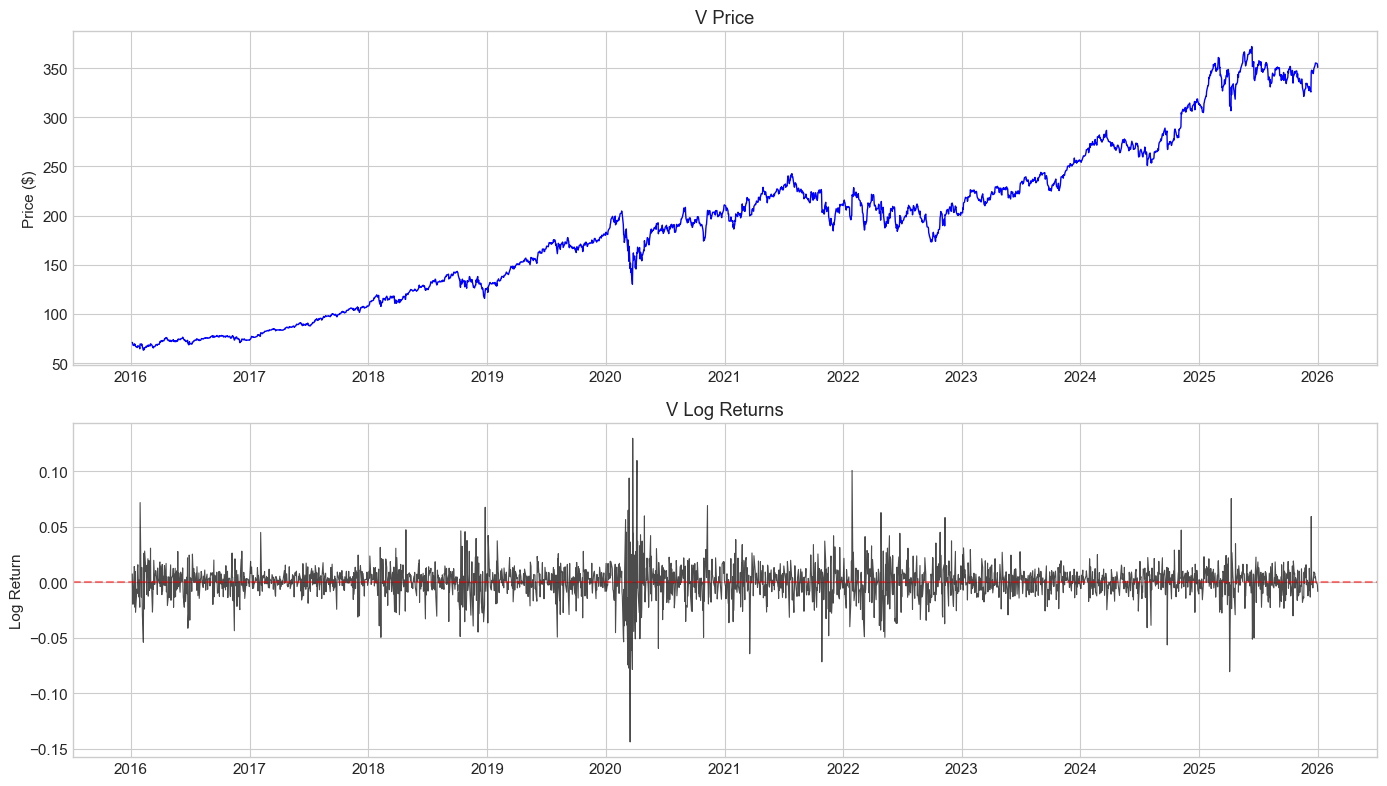

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df.index, df['Price'], 'b-', lw=1)
axes[0].set_title(f'{TICKER} Price')
axes[0].set_ylabel('Price ($)')
axes[1].plot(df.index, df['Return'], 'k-', alpha=0.7, lw=0.8)
axes[1].axhline(0, color='red', ls='--', alpha=0.5)
axes[1].set_title(f'{TICKER} Log Returns')
axes[1].set_ylabel('Log Return')
plt.tight_layout()
plt.show()

---
# Part A: ARIMA-GARCH (Two-Step Estimation)

**Methodology:**
1. **Step 1**: Determine `d` via ADF test (iterative)
2. **Step 2**: Grid search ARIMA(p,d,q) using statsmodels → select by AIC
3. **Step 3**: Fit GARCH(1,1) on ARIMA residuals → select distribution by AIC
4. **Step 4**: Diagnostics (Ljung-Box, ARCH-LM)
5. **Step 5**: Walk-forward backtest

### A.1: Stationarity Test & Optimal Differencing Order

In [6]:
def adf_test(series, name='Series', alpha=0.05):
    """Run ADF test and return (is_stationary, p_value, statistic)."""
    s = pd.Series(series).dropna()
    result = adfuller(s, autolag='AIC')
    stat, pval = result[0], result[1]
    print(f"ADF Test: {name}")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {pval:.4f}")
    print(f"  Stationary: {'Yes ✓' if pval < alpha else 'No ✗'}")
    return pval < alpha, pval, stat

def find_best_d_by_adf(series, base_name="Series", max_d=3, alpha=0.05):
    """
    Iteratively difference until ADF indicates stationarity.
    Returns (best_d, stationary_series, history).
    """
    s = pd.Series(series).dropna()
    history = []

    print("=" * 50)
    for d in range(0, max_d + 1):
        name = f"{base_name} (d={d})"
        is_stat, pval, stat = adf_test(s, name=name, alpha=alpha)
        history.append({"d": d, "p_value": pval, "stat": stat, "nobs": len(s)})
        print("-" * 50)

        if is_stat:
            print(f"\n✓ Stationary at d={d} (p={pval:.4f}).")
            print("=" * 50)
            return d, s, history

        if d < max_d:
            s = s.diff().dropna()

    print(f"\n⚠ Not stationary up to d={max_d}.")
    print("=" * 50)
    return None, s, history

In [7]:
# Test both Raw Price and Log Returns
print("\n" + "#" * 60)
print("# TESTING RAW PRICE")
print("#" * 60)
d_price, stationary_price, hist_price = find_best_d_by_adf(
    df['Price'], base_name="Raw Price", max_d=MAX_D
)

print("\n" + "#" * 60)
print("# TESTING LOG RETURNS")
print("#" * 60)
d_returns, stationary_returns, hist_returns = find_best_d_by_adf(
    df['Return'], base_name="Log Returns", max_d=MAX_D
)


############################################################
# TESTING RAW PRICE
############################################################
ADF Test: Raw Price (d=0)
  Statistic: -0.1287
  p-value:   0.9465
  Stationary: No ✗
--------------------------------------------------
ADF Test: Raw Price (d=1)
  Statistic: -15.5231
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=1 (p=0.0000).

############################################################
# TESTING LOG RETURNS
############################################################
ADF Test: Log Returns (d=0)
  Statistic: -14.7823
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=0 (p=0.0000).


In [8]:
# Decision: Which series to use for modelling
print("\n" + "=" * 60)
print("SERIES SELECTION FOR MODELLING")
print("=" * 60)

print(f"\nOption 1: Raw Price → requires d={d_price} differencing")
print(f"Option 2: Log Returns → requires d={d_returns} differencing")

# Prefer log returns if stationary at d=0 (no info loss from differencing)
if d_returns == 0:
    USE_SERIES = 'log_returns'
    SERIES_D = 0
    modelling_series = df['Return'].dropna()
    print(f"\n✓ SELECTED: Log Returns (d=0) - already stationary, no data loss")
elif d_price is not None:
    USE_SERIES = 'price'
    SERIES_D = d_price
    modelling_series = stationary_price
    print(f"\n✓ SELECTED: Differenced Price (d={d_price})")
else:
    USE_SERIES = 'log_returns'
    SERIES_D = d_returns if d_returns else 0
    modelling_series = stationary_returns
    print(f"\n✓ SELECTED: Log Returns (d={SERIES_D})")

print(f"\nModelling series length: {len(modelling_series)}")


SERIES SELECTION FOR MODELLING

Option 1: Raw Price → requires d=1 differencing
Option 2: Log Returns → requires d=0 differencing

✓ SELECTED: Log Returns (d=0) - already stationary, no data loss

Modelling series length: 2513


### A.2: ARIMA(p,d,q) Grid Search (Step 1 of Two-Step)

Using `statsmodels.tsa.arima.model.ARIMA` for the mean equation.

In [9]:
def fit_arima(series, order):
    """Fit ARIMA(p,d,q) and return (fit_result, AIC) or (None, inf) on failure."""
    try:
        model = ARIMA(series, order=order, trend="n") 
        fit = model.fit()
        return fit, fit.aic
    except:
        return None, np.inf

In [10]:
# Grid Search over ARIMA(p, d, q)
# Note: d is fixed from ADF test, but we include d=0 since we're using log returns
arima_results = []

print(f"ARIMA Grid Search: p ∈ [0,{MAX_AR}], d={SERIES_D}, q ∈ [0,{MAX_MA}]")
print("-" * 60)

for p in range(0, MAX_AR + 1):
    for q in range(0, MAX_MA + 1):
        order = (p, SERIES_D, q)
        fit, aic = fit_arima(modelling_series, order)
        if fit is not None:
            arima_results.append({
                'p': p, 'd': SERIES_D, 'q': q,
                'AIC': aic, 'BIC': fit.bic,
                'fit': fit
            })
            print(f"  ARIMA({p},{SERIES_D},{q}): AIC = {aic:.2f}, BIC = {fit.bic:.2f}")

arima_df = pd.DataFrame(arima_results).sort_values('AIC').reset_index(drop=True)

ARIMA Grid Search: p ∈ [0,4], d=0, q ∈ [0,4]
------------------------------------------------------------
  ARIMA(0,0,0): AIC = -13841.36, BIC = -13835.53
  ARIMA(0,0,1): AIC = -13873.71, BIC = -13862.05
  ARIMA(0,0,2): AIC = -13873.20, BIC = -13855.71
  ARIMA(0,0,3): AIC = -13871.17, BIC = -13847.85
  ARIMA(0,0,4): AIC = -13877.07, BIC = -13847.92
  ARIMA(1,0,0): AIC = -13874.99, BIC = -13863.33
  ARIMA(1,0,1): AIC = -13873.34, BIC = -13855.85
  ARIMA(1,0,2): AIC = -13871.28, BIC = -13847.97
  ARIMA(1,0,3): AIC = -13868.95, BIC = -13839.80
  ARIMA(1,0,4): AIC = -13893.91, BIC = -13858.93
  ARIMA(2,0,0): AIC = -13873.38, BIC = -13855.89
  ARIMA(2,0,1): AIC = -13871.38, BIC = -13848.06
  ARIMA(2,0,2): AIC = -13874.04, BIC = -13844.89
  ARIMA(2,0,3): AIC = -13867.03, BIC = -13832.06
  ARIMA(2,0,4): AIC = -13895.24, BIC = -13854.43
  ARIMA(3,0,0): AIC = -13871.38, BIC = -13848.06
  ARIMA(3,0,1): AIC = -13869.38, BIC = -13840.23
  ARIMA(3,0,2): AIC = -13867.44, BIC = -13832.46
  ARIMA(3,0,

In [11]:
# Select Best ARIMA
best_arima_row = arima_df.iloc[0]
BEST_P = int(best_arima_row['p'])
BEST_D = int(best_arima_row['d'])
BEST_Q = int(best_arima_row['q'])
best_arima_fit = best_arima_row['fit']

print(f"\n✓ BEST ARIMA: ARIMA({BEST_P},{BEST_D},{BEST_Q})")
print(f"  AIC: {best_arima_row['AIC']:.2f}")
print(f"  BIC: {best_arima_row['BIC']:.2f}")

print(len(arima_df))
print(arima_df.nsmallest(10, "AIC")[["p","d","q","AIC","BIC"]])


✓ BEST ARIMA: ARIMA(4,0,4)
  AIC: -13918.03
  BIC: -13865.57
25
   p  d  q           AIC           BIC
0  4  0  4 -13918.030671 -13865.567578
1  3  0  3 -13908.037793 -13867.233166
2  4  0  2 -13902.082238 -13861.277610
3  4  0  3 -13900.504371 -13853.870511
4  2  0  4 -13895.238940 -13854.434312
5  1  0  4 -13893.905448 -13858.930053
6  3  0  4 -13888.568096 -13841.934235
7  0  0  4 -13877.069210 -13847.923047
8  4  0  0 -13876.824086 -13847.677924
9  4  0  1 -13875.044145 -13840.068750


In [12]:
print(best_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 2513
Model:                 ARIMA(4, 0, 4)   Log Likelihood                6968.015
Date:                Mon, 19 Jan 2026   AIC                         -13918.031
Time:                        17:31:49   BIC                         -13865.568
Sample:                             0   HQIC                        -13898.989
                               - 2513                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2857      0.207     -1.383      0.167      -0.691       0.119
ar.L2          0.8060      0.199      4.045      0.000       0.416       1.197
ar.L3          0.1240      0.127      0.976      0.3

### A.3: GARCH on ARIMA Residuals (Step 2 of Two-Step)

Extract residuals from ARIMA, then fit GARCH(1,1) with different distributions.

In [13]:
# Extract ARIMA residuals
arima_resid = best_arima_fit.resid.dropna()

# Scale for GARCH numerical stability
arima_resid_scaled = arima_resid * 100

print(f"ARIMA residuals: {len(arima_resid)} observations")
print(f"Residual mean: {arima_resid.mean():.6f}")
print(f"Residual std:  {arima_resid.std():.6f}")

ARIMA residuals: 2513 observations
Residual mean: 0.000775
Residual std:  0.015103


In [14]:
# Test for ARCH effects in residuals
arch_test = het_arch(arima_resid_scaled, nlags=5)
print("ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)")
print(f"  LM Statistic: {arch_test[0]:.4f}")
print(f"  p-value:      {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("\n✓ ARCH effects detected → GARCH modelling is justified.")
else:
    print("\n⚠ No significant ARCH effects. GARCH may not add value.")

ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)
  LM Statistic: 380.3713
  p-value:      0.0000

✓ ARCH effects detected → GARCH modelling is justified.


In [15]:
garch_results = []
for dist in DISTRIBUTIONS:
    for lags in [0, 1, 2]:
        mean_type = "Zero" if lags == 0 else "AR"
        try:
            am = arch_model(
                arima_resid_scaled,
                mean=mean_type,
                lags=lags if lags > 0 else None,
                vol="Garch",
                p=1, q=1,
                dist=dist,
                rescale=False
            )
            fit = am.fit(disp="off", show_warning=False)
            garch_results.append({"Dist": dist, 
                                  "lags": lags, 
                                  "AIC": fit.aic, 
                                  "BIC": fit.bic,
                                  "LogLik": fit.loglikelihood, 
                                  "fit": fit})
        except:
            pass

garch_df = pd.DataFrame(garch_results).sort_values("AIC").reset_index(drop=True)
best_garch_fit = garch_df.iloc[0]["fit"]

print("\n" + "=" * 50)
print("GARCH Distribution Ranking:")
print(garch_df[['Dist', 'lags', 'AIC', 'BIC']])

std_resid = best_garch_fit.std_resid.dropna()
print(acorr_ljungbox(std_resid, lags=[5,10,15,20], return_df=True))
print(acorr_ljungbox(std_resid**2, lags=[5,10,15,20], return_df=True))


GARCH Distribution Ranking:
     Dist  lags          AIC          BIC
0   skewt     2  8260.798864  8307.426355
1   skewt     1  8267.556668  8308.358510
2       t     2  8285.986500  8326.785555
3   skewt     0  8287.368556  8316.514718
4       t     1  8291.214712  8326.187719
5       t     0  8344.267107  8367.584037
6  normal     2  8550.713466  8585.684084
7  normal     1  8555.324210  8584.468382
8  normal     0  8579.347562  8596.835259
      lb_stat  lb_pvalue
5   15.677153   0.007829
10  24.822941   0.005691
15  28.310984   0.019702
20  29.592736   0.076727
      lb_stat  lb_pvalue
5    3.201358   0.668974
10   7.833887   0.645059
15  12.955151   0.605762
20  14.790466   0.788269


In [16]:
# Select Best GARCH
best_garch_row = garch_df.iloc[0]
BEST_DIST = best_garch_row['Dist']
best_garch_fit = best_garch_row['fit']

print(f"\n✓ BEST GARCH: GARCH({GARCH_P},{GARCH_Q}) with {BEST_DIST} innovations")
print(f"\n✓ FULL MODEL: ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH({GARCH_P},{GARCH_Q})-{BEST_DIST}")




✓ BEST GARCH: GARCH(1,1) with skewt innovations

✓ FULL MODEL: ARIMA(4,0,4)-GARCH(1,1)-skewt


In [17]:
print(best_garch_fit.summary())

                                 AR - GARCH Model Results                                
Dep. Variable:                              None   R-squared:                      -0.001
Mean Model:                                   AR   Adj. R-squared:                 -0.002
Vol Model:                                 GARCH   Log-Likelihood:               -4122.40
Distribution:      Standardized Skew Student's t   AIC:                           8260.80
Method:                       Maximum Likelihood   BIC:                           8307.43
                                                   No. Observations:                 2511
Date:                           Mon, Jan 19 2026   Df Residuals:                     2508
Time:                                   17:31:50   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

### A.4: Residual Diagnostics

In [18]:
# Standardized residuals from GARCH
std_resid = best_garch_fit.std_resid.dropna()

# Ljung-Box Test
lb_test = acorr_ljungbox(std_resid, lags=[5, 10, 15, 20], return_df=True)
print("Ljung-Box Test (H0: No autocorrelation)")
print(lb_test)

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠ Some lags show autocorrelation.")
else:
    print("\n✓ No significant autocorrelation in standardized residuals.")

Ljung-Box Test (H0: No autocorrelation)
      lb_stat  lb_pvalue
5   15.677153   0.007829
10  24.822941   0.005691
15  28.310984   0.019702
20  29.592736   0.076727

⚠ Some lags show autocorrelation.


### Why Residual Autocorrelation Persists Sometimes (Not a Modelling Error)

**1. ARIMA is an approximation, not reality** 


ARIMA assumes finite memory, linear dynamics, and a single regime. Residual autocorrelation means not all dependence is linear / stationary/ finite-memory.

Equity markets violate all three. Even if ARIMA(3,0,4) is optimal within the ARIMA class, the class itself is misspecified relative to real market dynamics.


**2. GARCH removes variance dependence, not all dependence**  


GARCH ensures conditional variance is correctly modelled, not that residuals are fully independent.  
As a result:
- Squared standardised residuals are typically iid ✔  
- Raw standardised residuals may retain mild dependence ✖  
This behaviour is expected and normal.


**3. Large samples make Ljung–Box very sensitive**  


With long samples (e.g. >2000 observations), Ljung–Box detects even tiny, economically irrelevant correlations.  
Rejections at higher lags reflect statistical power, not model failure.

**Conclusion**  


Residual autocorrelation in this context arises from **market structure and model assumptions**, not from implementation errors.

In [19]:
# ARCH-LM Test on GARCH standardized residuals
arch_lm = het_arch(std_resid, nlags=5)
print("\nARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)")
print(f"  LM Statistic: {arch_lm[0]:.4f}")
print(f"  p-value:      {arch_lm[1]:.4f}")

if arch_lm[1] > 0.05:
    print("\n✓ No remaining ARCH effects. Variance model is adequate.")
else:
    print("\n⚠ Remaining ARCH effects. Consider higher GARCH order.")


ARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)
  LM Statistic: 3.1936
  p-value:      0.6702

✓ No remaining ARCH effects. Variance model is adequate.


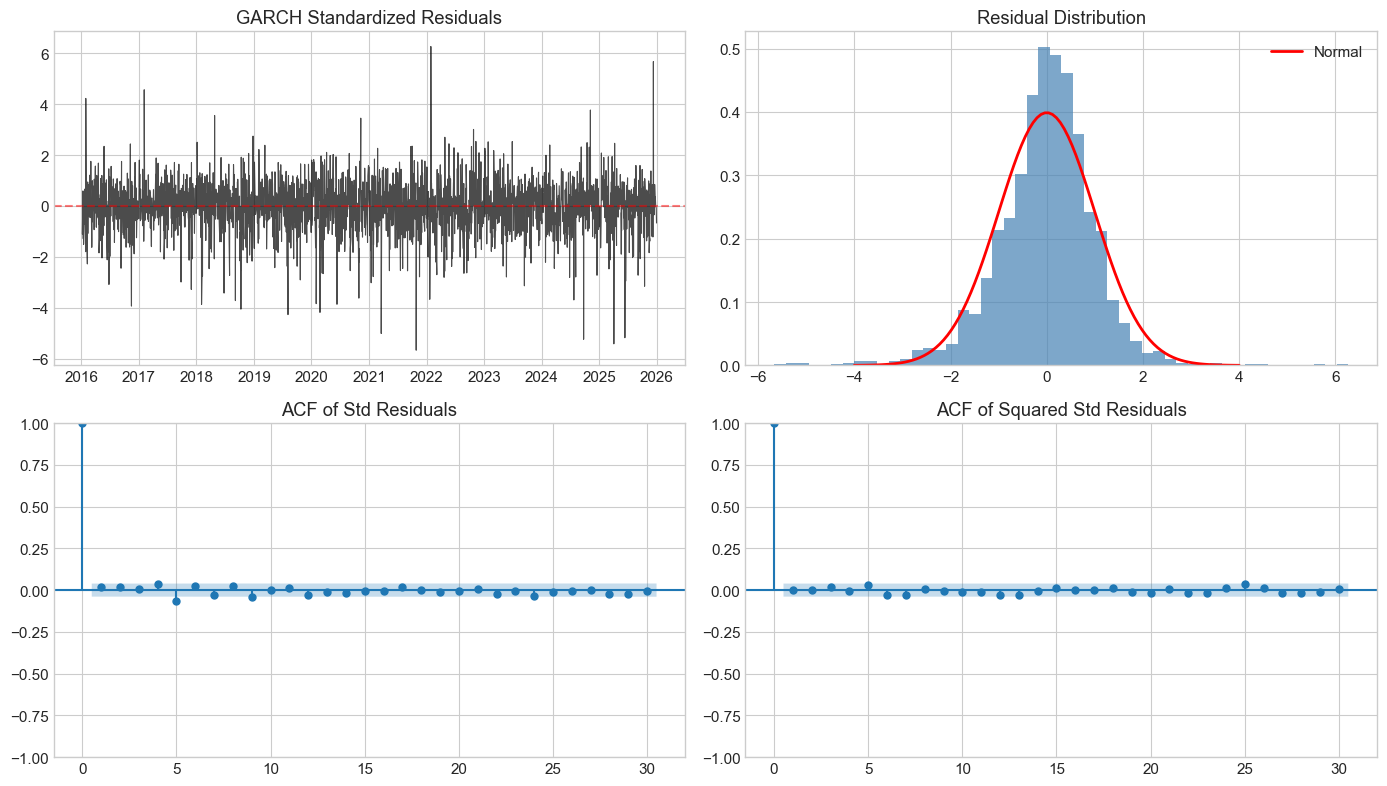

In [20]:
# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(std_resid.index, std_resid.values, 'k-', alpha=0.7, lw=0.8)
axes[0, 0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0, 0].set_title('GARCH Standardized Residuals')

axes[0, 1].hist(std_resid, bins=50, density=True, alpha=0.7, color='steelblue')
x = np.linspace(-4, 4, 100)
axes[0, 1].plot(x, stats.norm.pdf(x), 'r-', lw=2, label='Normal')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].legend()

plot_acf(std_resid, lags=30, ax=axes[1, 0], title='ACF of Std Residuals')
plot_acf(std_resid**2, lags=30, ax=axes[1, 1], title='ACF of Squared Std Residuals')

plt.tight_layout()
plt.show()

### A.5: In-Sample Volatility Bands

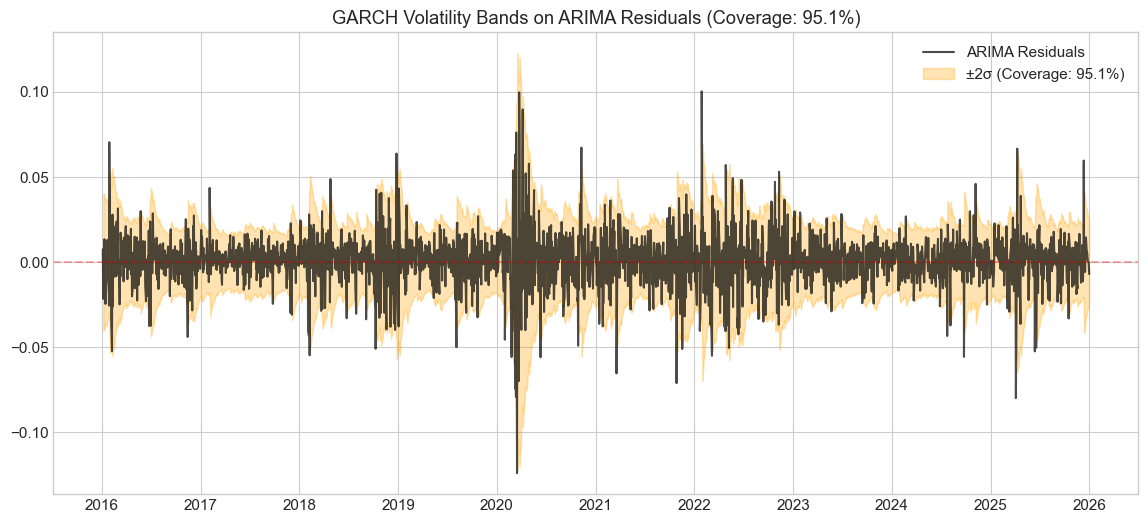

In [21]:
cond_vol = best_garch_fit.conditional_volatility / 100  # Unscale
aligned_resid = arima_resid.iloc[-len(cond_vol):]

inside = (aligned_resid.values > -2*cond_vol.values) & (aligned_resid.values < 2*cond_vol.values)
coverage = inside.mean()

plt.figure(figsize=(14, 6))
plt.plot(aligned_resid.index, aligned_resid.values, 'k-', alpha=0.7, label='ARIMA Residuals')
plt.fill_between(aligned_resid.index, -2*cond_vol.values, 2*cond_vol.values, 
                 alpha=0.3, color='orange', label=f'±2σ (Coverage: {coverage:.1%})')
plt.axhline(0, color='red', ls='--', alpha=0.3)
plt.title(f'GARCH Volatility Bands on ARIMA Residuals (Coverage: {coverage:.1%})')
plt.legend()
plt.show()

### A.6: Walk-Forward Backtest (Two-Step)

In [ ]:
series = modelling_series
train_end = len(series) - TEST_SIZE

arima_garch_forecasts, arima_garch_sigmas, actuals, dates = [], [], [], []
fail_count = 0

last_fc = np.nan
last_sigma = np.nan

for i in tqdm(range(TEST_SIZE), desc="ARIMA-GARCH Backtest"):
    train = series.iloc[:train_end + i]
    actual = series.iloc[train_end + i]
    date = series.index[train_end + i]

    try:
        # 1) Mean model (ensure trend matches your selection)
        arima_fit = ARIMA(train, order=(BEST_P, BEST_D, BEST_Q), trend="n").fit()
        arima_fc = float(arima_fit.forecast(steps=1).iloc[0])

        resid = arima_fit.resid.dropna()

        # 2) Vol model on residuals (no manual *100 scaling)
        am = arch_model(
            resid,
            mean="AR",
            lags=1,
            vol="Garch",
            p=GARCH_P,
            q=GARCH_Q,
            dist=BEST_DIST
        )
        gfit = am.fit(disp="off", show_warning=False)

        fcast = gfit.forecast(horizon=1, reindex=False)
        var1 = float(fcast.variance.values[-1, 0])
        vol_fc = float(np.sqrt(var1))

        last_fc, last_sigma = arima_fc, vol_fc

    except Exception:
        fail_count += 1
        # carry-forward
        arima_fc = last_fc
        vol_fc = last_sigma

    arima_garch_forecasts.append(arima_fc)
    arima_garch_sigmas.append(vol_fc)
    actuals.append(actual)
    dates.append(date)

print(f"Backtest finished. Failures handled: {fail_count}")

ARIMA-GARCH Backtest:   0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
arima_results = pd.DataFrame({
    'Date': dates,
    'Actual': actuals,
    'ARIMA_GARCH_Pred': arima_garch_forecasts,
    'ARIMA_GARCH_Sigma': arima_garch_sigmas
}).set_index('Date')

ag_mse = mean_squared_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_mae = mean_absolute_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_dir = np.mean(np.sign(arima_results['Actual']) == np.sign(arima_results['ARIMA_GARCH_Pred']))

print(f"\n=== ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST} Backtest ===")
print(f"MSE:           {ag_mse:.8f}")
print(f"MAE:           {ag_mae:.8f}")
print(f"Direction Acc: {ag_dir:.2%}")


=== ARIMA(4,0,4)-GARCH(1,1)-skewt Backtest ===
MSE:           0.00013259
MAE:           0.00818379
Direction Acc: 50.00%


In [ ]:
mu = np.array(arima_garch_forecasts)
sigma = np.array(arima_garch_sigmas)
y = np.array(actuals)

eps = 1e-12
z = mu / (sigma + eps)

def backtest_threshold(z, y, c, cost=0.0):
    # positions: +1 (Long), -1 (Short), 0 (Flat)
    pos = np.where(z > c, 1, np.where(z < -c, -1, 0))

    strat = pos * y
    turnover = np.abs(np.diff(pos, prepend=0))
    strat_net = strat - cost * turnover

    traded = pos != 0
    dir_acc = np.mean(strat[traded] > 0) if traded.any() else np.nan
    freq = traded.mean()

    return {
        "threshold_c": c,
        "trade_freq": freq,
        "dir_acc_traded": dir_acc,
        "mean_return": strat_net.mean(),
        "volatility": strat_net.std(ddof=1),
        "sharpe": (strat_net.mean() / (strat_net.std(ddof=1) + eps)) * np.sqrt(252),
        "positions": pos
    }



### Threshold Sweep Table and choosing of best threshold 


In [ ]:
# --- What it does:
# Runs a threshold sweep, prints a clean metrics table, and selects the best quantile/threshold by Sharpe.

quantiles = [0.60, 0.70, 0.80, 0.90]
results = []

for q in quantiles:
    c = np.quantile(np.abs(z), q)
    res = backtest_threshold(z, y, c, cost=0.0001)
    res["quantile"] = q
    results.append(res)

results_df = pd.DataFrame(results)[
    ["quantile", "threshold_c", "trade_freq", "dir_acc_traded",
     "mean_return", "volatility", "sharpe"]
].sort_values("sharpe", ascending=False)

print("\n=== Threshold Sweep (sorted by Sharpe) ===")
print(results_df.round(4).to_string(index=False))

best_row = results_df.iloc[0]
q_star = float(best_row["quantile"])
c_star = float(best_row["threshold_c"])

print(f"\nSelected threshold: quantile={q_star:.2f}, c={c_star:.4f} (best Sharpe)")


=== Threshold Sweep (sorted by Sharpe) ===
 quantile  threshold_c  trade_freq  dir_acc_traded  mean_return  volatility  sharpe
      0.6       0.0002      0.3929          0.6364       0.0002      0.0048  0.7115
      0.7       0.0008      0.3036          0.6471      -0.0001      0.0043 -0.3646
      0.8       0.0021      0.1964          0.6364      -0.0002      0.0029 -1.1812
      0.9       0.0071      0.1071          0.5000      -0.0004      0.0020 -2.7920

Selected threshold: quantile=0.60, c=0.0002 (best Sharpe)


### Next-day action

In [ ]:
# --- What it does:
# Creates an action table where today's signal determines NEXT day’s position (no look-ahead),
# and also prints a trades-only subset (non-FLAT days).

pos_raw = np.where(z > c_star, 1, np.where(z < -c_star, -1, 0))

# IMPORTANT: shift by 1 so the decision at time t is applied to return at time t+1
pos_next_day = pd.Series(pos_raw).shift(1).fillna(0).astype(int).to_numpy()

action_map = {1: "LONG", -1: "SHORT", 0: "FLAT"}
actions = pd.Series(pos_next_day).map(action_map)

actions_df = pd.DataFrame({
    "mu_hat": mu,
    "sigma_hat": sigma,
    "z_score": z,
    "position_next_day": pos_next_day,
    "action_next_day": actions,
    "actual_return": y
})

print("\n=== Action Table (next-day aligned) ===")
print(actions_df.head(10).round(4).to_string(index=False))

trades_only_df = actions_df[actions_df["position_next_day"] != 0].copy()
print("\n=== Trades Only (non-FLAT) ===")
print(trades_only_df.head(10).round(4).to_string(index=False))
print(f"\nTrade frequency (realised): {np.mean(pos_next_day != 0):.4f}")


=== Action Table (next-day aligned) ===
 mu_hat    sigma_hat  z_score  position_next_day action_next_day  actual_return
 0.0004       0.1732   0.0026                  0            FLAT         0.0013
-0.0002       0.0817  -0.0025                  1            LONG         0.0102
-0.0015       1.0180  -0.0015                 -1           SHORT        -0.0050
 0.0002      13.5765   0.0000                 -1           SHORT         0.0290
-0.0038       4.7912  -0.0008                  0            FLAT         0.0100
-0.0018  364899.8223  -0.0000                 -1           SHORT         0.0008
-0.0002       0.3164  -0.0006                  0            FLAT        -0.0131
-0.0003       0.0872  -0.0037                 -1           SHORT        -0.0072
-0.0001 2681617.7432  -0.0000                 -1           SHORT        -0.0036
-0.0006       0.1845  -0.0030                  0            FLAT        -0.0019

=== Trades Only (non-FLAT) ===
 mu_hat    sigma_hat  z_score  position_next_da

## Combined confidence + vol-targeted sizing + performance table

In [ ]:
# --- What it does:
# Converts mu/sigma into a continuous position size using BOTH:
# (i) confidence (z-score) and (ii) volatility targeting, with leverage caps and costs.
# Outputs summary metrics.

def size_confidence_vol_target(mu, sigma, sigma_target=0.01, c=0.5, k=1.0, w_max=2.0):
    """
    w_t = clip( (sigma_target / sigma_t) * f(z_t), -w_max, w_max )
    with f(z) = 0 if |z|<=c else k*(|z|-c)*sign(z)
    """
    eps = 1e-12
    z = mu / (sigma + eps)

    f = np.zeros_like(z)
    mask = np.abs(z) > c
    f[mask] = k * (np.abs(z[mask]) - c) * np.sign(z[mask])

    w = (sigma_target / (sigma + eps)) * f
    return np.clip(w, -w_max, w_max)

# Example hyperparams (tune these on VALIDATION only)
sigma_target = 0.01   # target daily vol (1%)
k = 1.0               # confidence scaling
w_max = 2.0           # leverage cap

w_raw = size_confidence_vol_target(mu, sigma, sigma_target=sigma_target, c=c_star, k=k, w_max=w_max)

# Next-day alignment (apply position decided at t to return at t+1)
w = pd.Series(w_raw).shift(1).fillna(0).to_numpy()

cost = 0.0001  # per unit turnover cost
turnover = np.abs(np.diff(w, prepend=0))
pnl_gross = w * y
pnl_net = pnl_gross - cost * turnover

ann_sharpe = (pnl_net.mean() / (pnl_net.std(ddof=1) + 1e-12)) * np.sqrt(252)

summary = pd.DataFrame([{
    "sigma_target": sigma_target,
    "threshold_c": c_star,
    "k": k,
    "w_max": w_max,
    "trade_freq_nonzero": float(np.mean(np.abs(w) > 0)),
    "mean_return": float(pnl_net.mean()),
    "volatility": float(pnl_net.std(ddof=1)),
    "sharpe": float(ann_sharpe),
}])

print("\n=== Confidence + Vol-Targeted Strategy Summary ===")
print(summary.round(6).to_string(index=False))


=== Confidence + Vol-Targeted Strategy Summary ===
 sigma_target  threshold_c   k  w_max  trade_freq_nonzero  mean_return  volatility   sharpe
         0.01     0.000236 1.0    2.0            0.392857     0.000001    0.000005 2.459499


---
# Part B: XGBoost

In [ ]:
N_LAGS = 5
VOL_WINDOW = 21

feature_df = df[['Return']].copy()
for lag in range(1, N_LAGS + 1):
    feature_df[f'lag_{lag}'] = feature_df['Return'].shift(lag)
feature_df['rolling_vol'] = feature_df['Return'].shift(1).rolling(VOL_WINDOW).std()
feature_df['ewma_vol'] = feature_df['Return'].shift(1).ewm(span=VOL_WINDOW).std()
feature_df.dropna(inplace=True)

FEATURE_COLS = [c for c in feature_df.columns if c != 'Return']
X_full = feature_df[FEATURE_COLS]
y_full = feature_df['Return']

print(f"Features: {FEATURE_COLS}")
print(f"Samples: {len(X_full)}")

Features: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_vol', 'ewma_vol']
Samples: 2242


In [ ]:
train_end = len(X_full) - TEST_SIZE

xgb_forecasts = []
xgb_actuals = []
xgb_dates = []

XGB_PARAMS = {
    'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05,
    'objective': 'reg:squarederror', 'verbosity': 0, 'n_jobs': -1,
    'random_state': RANDOM_SEED
}

for i in tqdm(range(TEST_SIZE), desc="XGBoost Backtest"):
    X_train = X_full.iloc[:train_end + i]
    y_train = y_full.iloc[:train_end + i]
    X_test = X_full.iloc[[train_end + i]]
    y_test = y_full.iloc[train_end + i]
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(**XGB_PARAMS)
    model.fit(X_train_s, y_train)
    pred = model.predict(X_test_s)[0]
    
    xgb_forecasts.append(pred)
    xgb_actuals.append(y_test)
    xgb_dates.append(X_full.index[train_end + i])

XGBoost Backtest:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
xgb_results = pd.DataFrame({
    'Date': xgb_dates, 'Actual': xgb_actuals, 'XGB_Pred': xgb_forecasts
}).set_index('Date')

xgb_mse = mean_squared_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_mae = mean_absolute_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_dir = np.mean(np.sign(xgb_results['Actual']) == np.sign(xgb_results['XGB_Pred']))

print(f"\n=== XGBoost Backtest ===")
print(f"MSE:           {xgb_mse:.8f}")
print(f"MAE:           {xgb_mae:.8f}")
print(f"Direction Acc: {xgb_dir:.2%}")


=== XGBoost Backtest ===
MSE:           0.00013256
MAE:           0.00785557
Direction Acc: 60.71%


---
# Part C: LSTM

In [ ]:

# -----------------------------
# Model
# -----------------------------
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # last time step

# -----------------------------
# Config
# -----------------------------
LSTM_CONFIG = {
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.0,
    "epochs_refit": 15,      # fewer epochs when we do full refit
    "epochs_update": 2,      # small incremental updates between refits
    "lr": 1e-3,              # 0.01 is often too high for LSTM stability
    "seq_length": 10,
    "batch_size": 64,
    "window": 504,           # rolling window length (~2 years)
    "refit_every": 5,        # refit weekly (every 5 trading days)
    "grad_clip": 1.0,
}

print(f"LSTM Config: {LSTM_CONFIG}")

LSTM Config: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.0, 'epochs_refit': 15, 'epochs_update': 2, 'lr': 0.001, 'seq_length': 10, 'batch_size': 64, 'window': 504, 'refit_every': 5, 'grad_clip': 1.0}


In [ ]:
def make_sequences(X2d: np.ndarray, y1d: np.ndarray, seq_len: int):
    """
    Build supervised sequences:
      X_seq[t] = X[t-seq_len : t]  (seq_len rows)
      y_seq[t] = y[t]
    Returns:
      X_seq: (N, seq_len, n_features)
      y_seq: (N, 1)
    """
    X_seq, y_seq = [], []
    for t in range(seq_len, len(X2d)):
        X_seq.append(X2d[t - seq_len : t])
        y_seq.append(y1d[t])
    X_seq = np.asarray(X_seq, dtype=np.float32)
    y_seq = np.asarray(y_seq, dtype=np.float32).reshape(-1, 1)
    return X_seq, y_seq

def fit_one_epoch(model, loader, opt, loss_fn, device, grad_clip=None):
    model.train()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_full = df['Return']
X_full = df[['Return']]

SEQ_LEN = LSTM_CONFIG["seq_length"]
WINDOW = LSTM_CONFIG["window"]
REFIT_EVERY = LSTM_CONFIG["refit_every"]
BATCH_SIZE = LSTM_CONFIG["batch_size"]

train_end = len(X_full) - TEST_SIZE

lstm_forecasts = []
lstm_actuals = []
lstm_dates = []

model = None
opt = None
loss_fn = nn.MSELoss()
scaler_X = None

# Keep these cached so we don't rebuild everything unless refit/update needs it
X_seq_cache = None
y_seq_cache = None
loader_cache = None

for i in tqdm(range(TEST_SIZE), desc="LSTM Backtest (rolling+refit)"):
    # -----------------------------
    # Define rolling training window [start : end)
    # -----------------------------
    end_ix = train_end + i  # exclusive end for training data
    start_ix = max(0, end_ix - WINDOW)

    X_train = X_full.iloc[start_ix:end_ix].values
    y_train = y_full.iloc[start_ix:end_ix].values

    # Need enough rows to make sequences
    if len(X_train) <= SEQ_LEN + 5:
        lstm_forecasts.append(0.0)
        lstm_actuals.append(y_full.iloc[end_ix])
        lstm_dates.append(X_full.index[end_ix])
        continue

    # -----------------------------
    # Refit scaler on the rolling window (prevents leakage)
    # -----------------------------
    scaler_X = StandardScaler()
    X_train_s = scaler_X.fit_transform(X_train)

    # Build sequences for training
    X_seq, y_seq = make_sequences(X_train_s, y_train, SEQ_LEN)

    # DataLoader (mini-batches)
    dataset = TensorDataset(torch.from_numpy(X_seq), torch.from_numpy(y_seq))
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

    # -----------------------------
    # Model init / refit schedule
    # -----------------------------
    need_full_refit = (model is None) or (i % REFIT_EVERY == 0)

    if need_full_refit:
        # Full (but still lightweight) refit
        model = LSTMNet(
            input_size=X_train.shape[1],
            hidden_size=LSTM_CONFIG["hidden_size"],
            num_layers=LSTM_CONFIG["num_layers"],
            dropout=LSTM_CONFIG["dropout"]
        ).to(device)
        opt = optim.Adam(model.parameters(), lr=LSTM_CONFIG["lr"])

        for _ in range(LSTM_CONFIG["epochs_refit"]):
            fit_one_epoch(
                model, loader, opt, loss_fn, device,
                grad_clip=LSTM_CONFIG["grad_clip"]
            )
    else:
        # Warm update (few epochs) to adapt
        for _ in range(LSTM_CONFIG["epochs_update"]):
            fit_one_epoch(
                model, loader, opt, loss_fn, device,
                grad_clip=LSTM_CONFIG["grad_clip"]
            )

    # -----------------------------
    # Predict next-day action/return using the most recent SEQ_LEN feature rows
    # (aligned so the sequence ends at end_ix-1)
    # -----------------------------
    X_hist = X_full.iloc[end_ix - SEQ_LEN : end_ix].values  # exactly SEQ_LEN rows
    X_hist_s = scaler_X.transform(X_hist)
    X_test_t = torch.tensor(X_hist_s, dtype=torch.float32).unsqueeze(0).to(device)  # (1, seq_len, n_features)

    model.eval()
    with torch.no_grad():
        pred = model(X_test_t).item()

    # Store (prediction is for y at index end_ix, i.e., next point after the window)
    lstm_forecasts.append(pred)
    lstm_actuals.append(y_full.iloc[end_ix])
    lstm_dates.append(X_full.index[end_ix])

# Convert to Series (nice for later evaluation/plotting)
lstm_forecasts = pd.Series(lstm_forecasts, index=lstm_dates, name="lstm_pred")
lstm_actuals = pd.Series(lstm_actuals, index=lstm_dates, name="actual")

LSTM Backtest (rolling+refit):   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
lstm_results = pd.DataFrame({
    'Date': lstm_dates, 'Actual': lstm_actuals, 'LSTM_Pred': lstm_forecasts
}).set_index('Date')

lstm_mse = mean_squared_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_mae = mean_absolute_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_dir = np.mean(np.sign(lstm_results['Actual']) == np.sign(lstm_results['LSTM_Pred']))

print(f"\n=== LSTM Backtest ===")
print(f"MSE:           {lstm_mse:.8f}")
print(f"MAE:           {lstm_mae:.8f}")
print(f"Direction Acc: {lstm_dir:.2%}")


=== LSTM Backtest ===
MSE:           0.00013873
MAE:           0.00832933
Direction Acc: 42.86%


---
# Part D: Consolidated Comparison

In [ ]:
comparison = arima_results[['Actual', 'ARIMA_GARCH_Pred']].copy()
comparison['XGB_Pred'] = xgb_results['XGB_Pred']
comparison['LSTM_Pred'] = lstm_results['LSTM_Pred']
comparison.head()

,Actual,ARIMA_GARCH_Pred,XGB_Pred,LSTM_Pred
Date,,,,
2024-10-11 04:00:00,0.001345,0.000448,0.000924,0.000035
2024-10-14 04:00:00,0.010189,-0.000201,0.000601,-0.000194
2024-10-15 04:00:00,-0.004973,-0.001494,0.000388,0.000026
2024-10-16 04:00:00,0.029019,0.000167,0.000688,-0.000532
2024-10-17 04:00:00,0.009952,-0.003847,0.000044,-0.000193


In [ ]:
def compute_metrics(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'Direction Acc': np.mean(np.sign(actual) == np.sign(predicted))
    }

model_name = f'ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST}'
metrics = {
    model_name: compute_metrics(comparison['Actual'], comparison['ARIMA_GARCH_Pred']),
    'XGBoost': compute_metrics(comparison['Actual'], comparison['XGB_Pred']),
    'LSTM': compute_metrics(comparison['Actual'], comparison['LSTM_Pred'])
}

metrics_df = pd.DataFrame(metrics).T.sort_values('MSE')

print("=" * 70)
print(f"MODEL COMPARISON: {TICKER} ({TEST_SIZE}-day walk-forward backtest)")
print("=" * 70)
display(metrics_df.round(6))
print(f"\n✓ BEST (MSE): {metrics_df.index[0]}")
print(f"✓ BEST (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")

MODEL COMPARISON: V (56-day walk-forward backtest)


,MSE,MAE,Direction Acc
XGBoost,0.000133,0.007856,0.607143
"ARIMA(4,0,4)-GARCH(1,1)-skewt",0.000133,0.008184,0.500000
LSTM,0.000139,0.008329,0.428571



✓ BEST (MSE): XGBoost
✓ BEST (Direction): XGBoost


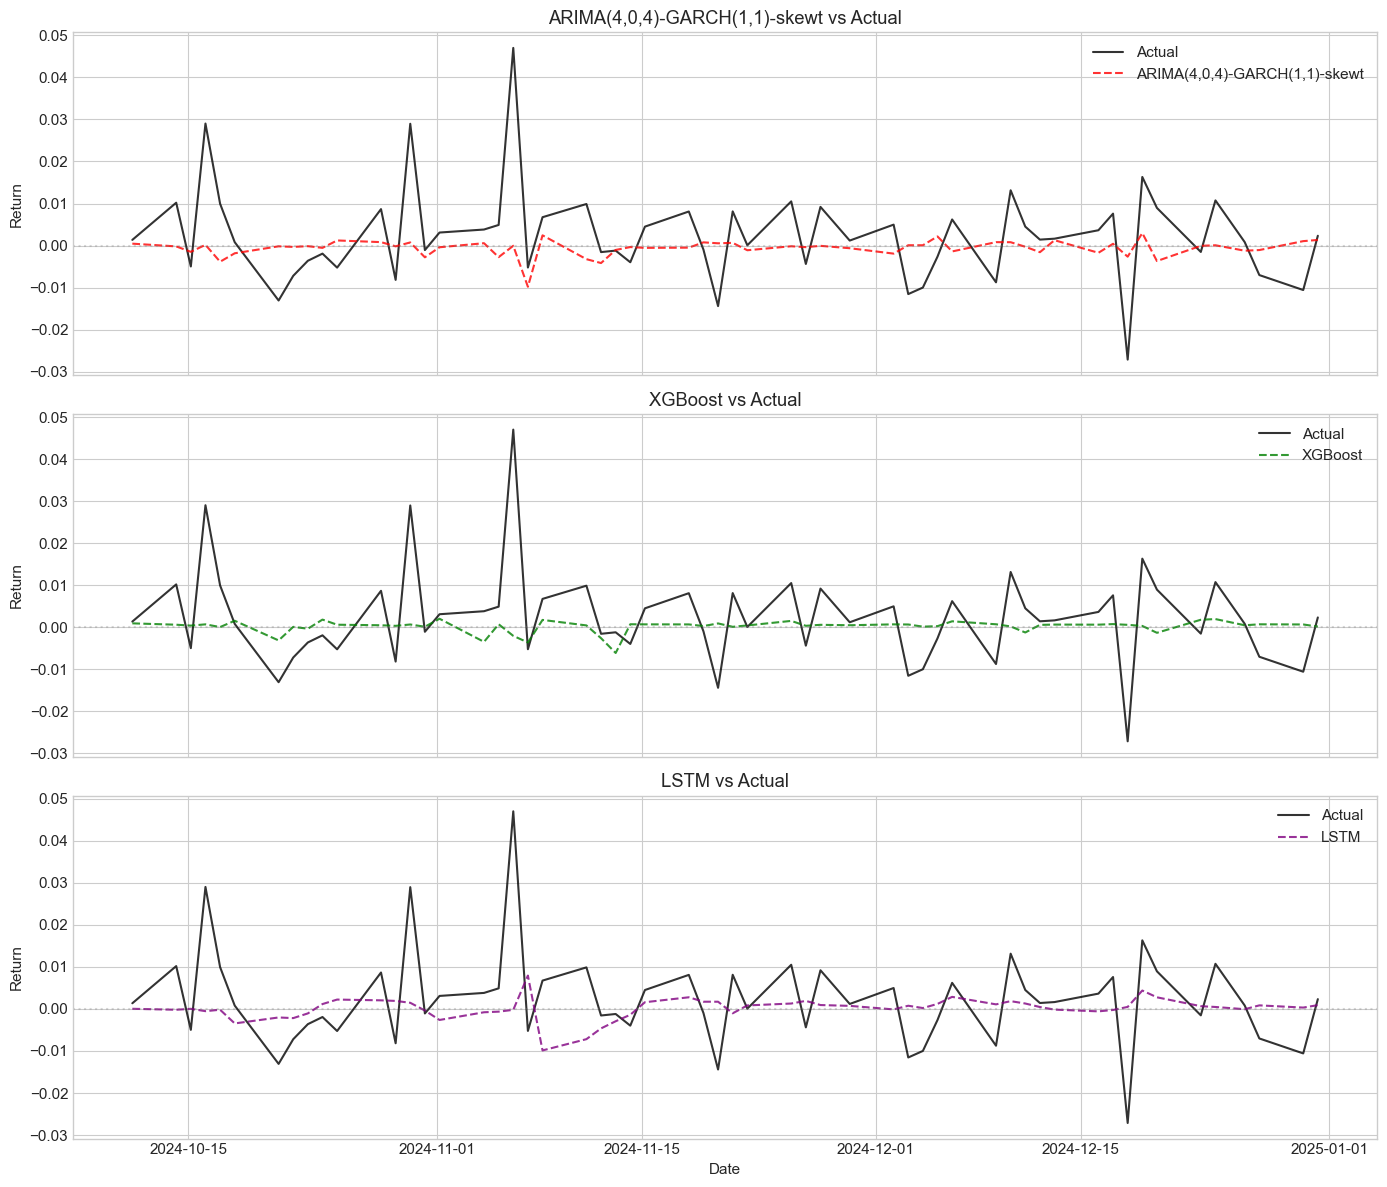

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
models = ['ARIMA_GARCH_Pred', 'XGB_Pred', 'LSTM_Pred']
titles = [model_name, 'XGBoost', 'LSTM']
colors = ['red', 'green', 'purple']

for ax, m, title, c in zip(axes, models, titles, colors):
    ax.plot(comparison.index, comparison['Actual'], 'k-', label='Actual', alpha=0.8, lw=1.5)
    ax.plot(comparison.index, comparison[m], color=c, ls='--', label=title, alpha=0.8)
    ax.axhline(0, color='gray', ls=':', alpha=0.3)
    ax.set_title(f'{title} vs Actual')
    ax.set_ylabel('Return')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

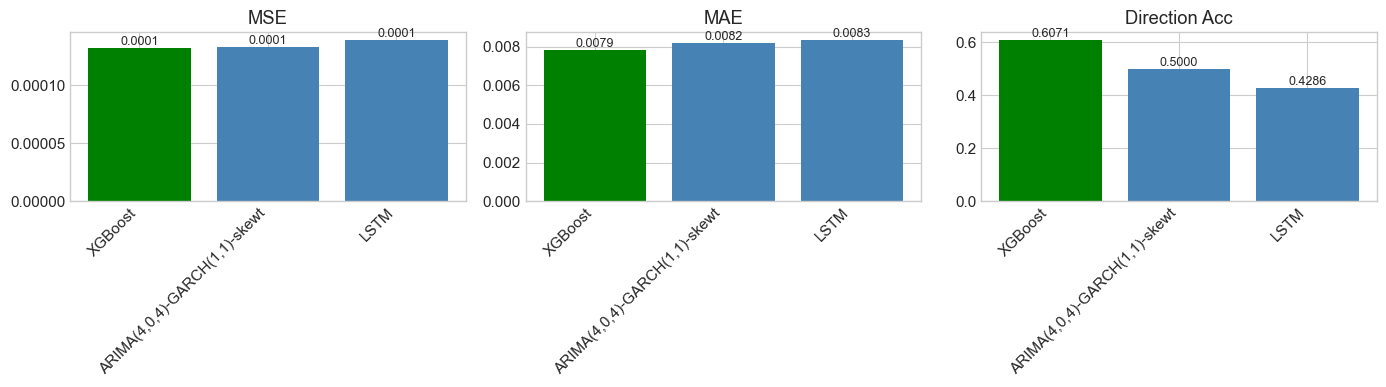

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, metric in enumerate(['MSE', 'MAE', 'Direction Acc']):
    vals = metrics_df[metric].values
    clrs = ['green' if v == (vals.max() if metric == 'Direction Acc' else vals.min()) else 'steelblue' for v in vals]
    axes[i].bar(range(len(metrics_df)), vals, color=clrs)
    axes[i].set_xticks(range(len(metrics_df)))
    axes[i].set_xticklabels(metrics_df.index, rotation=45, ha='right')
    axes[i].set_title(metric)
    for j, v in enumerate(vals):
        axes[i].text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

---
## Final Summary

In [ ]:
print("=" * 75)
print(f"FINAL REPORT: {TICKER}")
print("=" * 75)
print(f"\nData: {START_DATE} to {END_DATE} ({len(df)} obs)")
print(f"Backtest: Last {TEST_SIZE} days (walk-forward, expanding window)")
print(f"\nARIMA-GARCH Selection (Two-Step):")
print(f"  Series: {'Log Returns' if USE_SERIES == 'log_returns' else 'Differenced Price'}")
print(f"  ARIMA Grid: p∈[0,{MAX_AR}], d={SERIES_D}, q∈[0,{MAX_MA}]")
print(f"  Best ARIMA: ({BEST_P},{BEST_D},{BEST_Q})")
print(f"  GARCH: (1,1) with {BEST_DIST} innovations")
print(f"\n{'Model':<40} {'MSE':<12} {'MAE':<12} {'Dir Acc':<12}")
print("-" * 76)
for m, row in metrics_df.iterrows():
    print(f"{m:<40} {row['MSE']:<12.6f} {row['MAE']:<12.6f} {row['Direction Acc']:<12.2%}")
print("-" * 76)
print(f"\n✓ Winner (MSE):       {metrics_df.index[0]}")
print(f"✓ Winner (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")

FINAL REPORT: V

Data: 2002-01-01 to 2024-12-31 (2263 obs)
Backtest: Last 56 days (walk-forward, expanding window)

ARIMA-GARCH Selection (Two-Step):
  Series: Log Returns
  ARIMA Grid: p∈[0,4], d=0, q∈[0,4]
  Best ARIMA: (4,0,4)
  GARCH: (1,1) with skewt innovations

Model                                    MSE          MAE          Dir Acc     
----------------------------------------------------------------------------
XGBoost                                  0.000133     0.007856     60.71%      
ARIMA(4,0,4)-GARCH(1,1)-skewt            0.000133     0.008184     50.00%      
LSTM                                     0.000139     0.008329     42.86%      
----------------------------------------------------------------------------

✓ Winner (MSE):       XGBoost
✓ Winner (Direction): XGBoost
